In [ ]:
!chmod 600 ~/.passwd-s3fs

In [ ]:
!apt install s3fs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  s3fs
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 234 kB of archives.
After this operation, 678 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 s3fs amd64 1.86-1 [234 kB]
Fetched 234 kB in 2s (137 kB/s)
Selecting previously unselected package s3fs.
(Reading database ... 129504 files and directories currently installed.)
Preparing to unpack .../archives/s3fs_1.86-1_amd64.deb ...
Unpacking s3fs (1.86-1) ...
Setting up s3fs (1.86-1) ...
Processing triggers for man-db (2.9.1-1) ...


In [ ]:
!mkdir /content/s3
!s3fs um2ii-datasets /content/s3

In [ ]:
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
import os
from glob import glob
from sklearn import metrics

CheXpert Age Validation on MIMIC Dataset

In [ ]:
df = pd.read_csv('/content/mimic_age_split.csv')
df['path'] = 's3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
chexpert_age_model = load_learner('/content/chexpert_age.pkl')

In [ ]:
chexpert_age_model.dls.to(device='cuda')
chexpert_age_model.model.to(device='cuda')
age_test_dl = chexpert_age_model.dls.test_dl(test_df)
age_preds = chexpert_age_model.get_preds(dl=age_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Age'] = test_df[['Patient Age Category']]
predict_df['Age_Tensor_Id'] =age_preds[2].numpy()
predict_df['Age_Probability'] =age_preds[0].numpy().tolist()

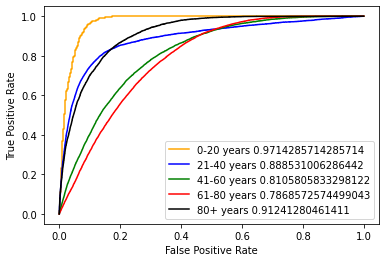

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[0] for prob in predict_df['Age_Probability']], pos_label = '0.0')
plt.plot(fpr,tpr, color='orange', label='0-20 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[1] for prob in predict_df['Age_Probability']], pos_label = '1.0')
plt.plot(fpr,tpr, color='blue', label='21-40 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[2] for prob in predict_df['Age_Probability']], pos_label = '2.0')
plt.plot(fpr,tpr, color='green', label='41-60 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[3] for prob in predict_df['Age_Probability']], pos_label = '3.0')
plt.plot(fpr,tpr, color='red', label='61-80 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[4] for prob in predict_df['Age_Probability']], pos_label = '4.0')
plt.plot(fpr,tpr, color='black', label='80+ years ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Age_Tensor_Id', age_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Age_Probability', age_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/chexpert_age_mimic_test.csv')

         index                                      dicom_id  subject_id  \
113        413  8159799c-7615c0ba-9676dd65-8b0cd6ed-96872c8f    10004322   
134        453  2e35d425-77612af9-262e207e-71a75b67-78fa40d1    10007920   
139        463  eee6e206-f7bc49c7-563f869c-ee75184d-c81e2907    10008304   
140        464  b4044414-100334a0-2f49c69e-7c0fce26-d332f756    10008304   
141        465  fc08b4f9-a67dd3a8-8bc68820-858e5989-bb651ebd    10009049   
...        ...                                           ...         ...   
224682  630338  e3e5f8c3-14429887-b1181522-445ec3a8-110663c3    19998562   
224683  630339  b70ca192-74b20b3e-669f166c-beec4177-2ece8df2    19998562   
224684  630340  12fad032-cf4eff00-32a4fc65-67e424b6-a2e42afb    19998562   
224687  630343  3fcd0406-9b111603-feae7033-96632b3a-111333e5    19999733   
224688  630344  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
113     576629

NIH Age Validation on MIMIC Dataset

In [ ]:
df = pd.read_csv('/content/mimic_age_split.csv')
df['path'] = 's3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
nih_age_model = load_learner('/content/nih_age.pkl')

In [ ]:
nih_age_model.dls.to(device='cuda:2')
nih_age_model.model.to(device='cuda:2')
age_test_dl = nih_age_model.dls.test_dl(test_df, num_workers = 10)
age_preds = nih_age_model.get_preds(dl=age_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Age'] = test_df[['Patient Age Category']]
predict_df['Age_Tensor_Id'] =age_preds[2].numpy()
predict_df['Age_Probability'] =age_preds[0].numpy().tolist()

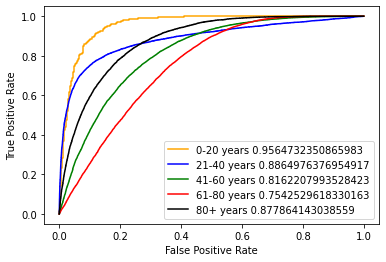

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[0] for prob in predict_df['Age_Probability']], pos_label = '0.0')
plt.plot(fpr,tpr, color='orange', label='0-20 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[1] for prob in predict_df['Age_Probability']], pos_label = '1.0')
plt.plot(fpr,tpr, color='blue', label='21-40 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[2] for prob in predict_df['Age_Probability']], pos_label = '2.0')
plt.plot(fpr,tpr, color='green', label='41-60 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[3] for prob in predict_df['Age_Probability']], pos_label = '3.0')
plt.plot(fpr,tpr, color='red', label='61-80 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[4] for prob in predict_df['Age_Probability']], pos_label = '4.0')
plt.plot(fpr,tpr, color='black', label='80+ years ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Age_Tensor_Id', age_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Age_Probability', age_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/nih_age_mimic_test.csv')

         index                                      dicom_id  subject_id  \
113        413  8159799c-7615c0ba-9676dd65-8b0cd6ed-96872c8f    10004322   
134        453  2e35d425-77612af9-262e207e-71a75b67-78fa40d1    10007920   
139        463  eee6e206-f7bc49c7-563f869c-ee75184d-c81e2907    10008304   
140        464  b4044414-100334a0-2f49c69e-7c0fce26-d332f756    10008304   
141        465  fc08b4f9-a67dd3a8-8bc68820-858e5989-bb651ebd    10009049   
...        ...                                           ...         ...   
224682  630338  e3e5f8c3-14429887-b1181522-445ec3a8-110663c3    19998562   
224683  630339  b70ca192-74b20b3e-669f166c-beec4177-2ece8df2    19998562   
224684  630340  12fad032-cf4eff00-32a4fc65-67e424b6-a2e42afb    19998562   
224687  630343  3fcd0406-9b111603-feae7033-96632b3a-111333e5    19999733   
224688  630344  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
113     576629

MIMIC Age Validation on MIMIC Dataset

In [ ]:
df = pd.read_csv('/content/mimic_age_split.csv')
df['path'] = '/content/s3/MIMIC/mimic-cxr-jpg/2.0.0/' + df['path'].astype(str)
df['path']=df['path'].str.replace('dcm','jpg')
test_df = df[df.split=='test']
test_df = test_df.rename(columns={'path': "Path"})
mimic_age_model = load_learner('/content/mimic_age.pkl')

In [ ]:
mimic_age_model.dls.to(device='cuda')
mimic_age_model.model.to(device='cuda')
age_test_dl = mimic_age_model.dls.test_dl(test_df, num_workers = 10)
age_preds = mimic_age_model.get_preds(dl=age_test_dl, with_decoded=True)

In [ ]:
predict_df = pd.DataFrame(test_df[['Path']])
predict_df['Age'] = test_df[['Patient Age Category']]
predict_df['Age_Tensor_Id'] =age_preds[2].numpy()
predict_df['Age_Probability'] =age_preds[0].numpy().tolist()

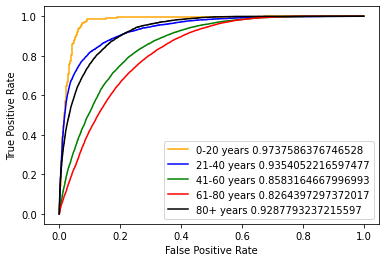

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[0] for prob in predict_df['Age_Probability']], pos_label = '0.0')
plt.plot(fpr,tpr, color='orange', label='0-20 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[1] for prob in predict_df['Age_Probability']], pos_label = '1.0')
plt.plot(fpr,tpr, color='blue', label='21-40 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[2] for prob in predict_df['Age_Probability']], pos_label = '2.0')
plt.plot(fpr,tpr, color='green', label='41-60 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[3] for prob in predict_df['Age_Probability']], pos_label = '3.0')
plt.plot(fpr,tpr, color='red', label='61-80 years ' + str(metrics.auc(fpr, tpr)))
fpr, tpr, _ = metrics.roc_curve(y_true = predict_df['Age'].astype(str),y_score = [prob[4] for prob in predict_df['Age_Probability']], pos_label = '4.0')
plt.plot(fpr,tpr, color='black', label='80+ years ' + str(metrics.auc(fpr, tpr)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
test_df.insert(len(test_df.columns), 'Age_Tensor_Id', age_preds[2].numpy())
test_df.insert(len(test_df.columns), 'Age_Probability', age_preds[0].numpy().tolist())
print(test_df)
test_df.to_csv('/content/sample_data/mimic_age_mimic_test.csv')

         index                                      dicom_id  subject_id  \
113        413  8159799c-7615c0ba-9676dd65-8b0cd6ed-96872c8f    10004322   
134        453  2e35d425-77612af9-262e207e-71a75b67-78fa40d1    10007920   
139        463  eee6e206-f7bc49c7-563f869c-ee75184d-c81e2907    10008304   
140        464  b4044414-100334a0-2f49c69e-7c0fce26-d332f756    10008304   
141        465  fc08b4f9-a67dd3a8-8bc68820-858e5989-bb651ebd    10009049   
...        ...                                           ...         ...   
224682  630338  e3e5f8c3-14429887-b1181522-445ec3a8-110663c3    19998562   
224683  630339  b70ca192-74b20b3e-669f166c-beec4177-2ece8df2    19998562   
224684  630340  12fad032-cf4eff00-32a4fc65-67e424b6-a2e42afb    19998562   
224687  630343  3fcd0406-9b111603-feae7033-96632b3a-111333e5    19999733   
224688  630344  428e2c18-5721d8f3-35a05001-36f3d080-9053b83c    19999733   

        study_id PerformedProcedureStepDescription ViewPosition  Rows  \
113     576629